In [1]:
# fix old Torch installs
!pip uninstall -y torch torchvision torchaudio torchao torchdata -q || true

# version we need
!pip install --quiet torch==1.13.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu
!pip install --quiet transformers==4.38.0
!pip install --quiet minicons==0.1.17
!pip install --quiet https://github.com/kpu/kenlm/archive/master.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 MB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
timm 1.0.19 requires torchvision, which is not installed.
accelerate 1.9.0 requires torch>=2.0.0, but you have torch 1.13.1+cpu which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, which is not installed.
sentence-transformers 5.0.0 requires transformers

Setup: install system dependencies, build KenLM C++ binaries, and install Python packages (TensorFlow CPU, NumPy, Transformers, etc.).

In [1]:
# get system tools & libs for KenLM
!apt-get update -qq && apt-get install -y build-essential cmake libbz2-dev zlib1g-dev libboost-all-dev

!git clone --depth 1 https://github.com/kpu/kenlm.git
!cd kenlm && mkdir -p build && cd build && cmake .. && make -j4

# install the Python wrapper
!pip install --quiet https://github.com/kpu/kenlm/archive/master.zip

# make sure NumPy is under v2 for compatibility
!pip install --quiet "numpy<2.0.0"

# bring in TF CPU and some handy data/analysis libs
!pip install --quiet tensorflow-cpu transformers pandas tqdm seaborn statsmodels

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libbz2-dev is already the newest version (1.0.8-5build1).
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
fatal: destination path 'kenlm' already exists and is not an empty directory.
CMake Warning (dev) at CMakeLists.txt:101 (find_package):
  Policy CMP0167 is not set: The FindBoost module is removed.  Run "cmake
  --help-policy CMP0167" for policy details.  Use the cmake_policy command to
  set the policy and suppress this warning.



Load & inspect the data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from pathlib import Path

CSV_PATH = Path("/content/drive/MyDrive/languge project csv/ia_Paragraph_ordinary.csv")
ia = pd.read_csv(CSV_PATH)

# Clean names: strip whitespace & keep original case & drop duplicates
ia.columns = ia.columns.str.strip()
ia = ia.loc[:, ~ia.columns.duplicated(keep="first")]

WORD_COL = "IA_LABEL"        # token text column
print("Using WORD_COL =", WORD_COL)
ia.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using WORD_COL = IA_LABEL


,participant_id,TRIAL_INDEX,EYE_REPORTED,EYE_TRACKED,IA_AREA,IA_AVERAGE_FIX_PUPIL_SIZE,IA_BOTTOM,IA_DWELL_TIME,IA_DWELL_TIME_%,IA_FIRST_FIXATION_DURATION,...,dependency_relation,morphological_features,entity_type,Reduced_POS,head_word_index,left_dependents_count,right_dependents_count,distance_to_head,selected_answer,is_correct
0,l59_485,1,RIGHT,Right,16872.0,668.89,264,2171,0.1434,311,...,amod,"['Aspect=Prog', 'Tense=Pres', 'VerbForm=Part']",NaN,VERB,3,0,0,2,B,False
1,l59_485,1,RIGHT,Right,12654.0,657.50,264,876,0.0578,292,...,compound,['Number=Sing'],NaN,NOUN,3,0,0,1,B,False
2,l59_485,1,RIGHT,Right,23199.0,669.67,264,640,0.0423,191,...,nsubj,['Number=Plur'],NaN,NOUN,5,2,0,2,B,False
3,l59_485,1,RIGHT,Right,10545.0,691.50,264,586,0.0387,271,...,aux,"['Mood=Ind', 'Tense=Pres', 'VerbForm=Fin']",NaN,FUNC,5,0,0,1,B,False
4,l59_485,1,RIGHT,Right,14763.0,.,264,0,0.0000,.,...,ROOT,"['Aspect=Perf', 'Tense=Past', 'VerbForm=Part']",NaN,VERB,5,2,4,0,B,False


Build external training corpus from WikiText-103

In [3]:
# Build an external training text from WikiText-103 parquet shards in Drive
from google.colab import drive
drive.mount('/content/drive')

import os, re
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/content/drive/MyDrive/languge project csv")
shards = sorted(DATA_DIR.glob("train-*.parquet"))
assert len(shards) > 0, f"No train-*.parquet files found under: {DATA_DIR}"

# Ensure parquet support
try:
    import pyarrow
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "pyarrow"], check=True)

os.makedirs("/content/corpus", exist_ok=True)
EXTERNAL_TRAIN_TXT = Path("/content/corpus/external_train.txt")

def normalize_line(s: str) -> str:
    s = s.strip()
    s = re.sub(r'([.,!?;:()"“”\'`])', r' \1 ', s)  # space punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s  # keep case to match scoring

lines_written = 0
with EXTERNAL_TRAIN_TXT.open("w", encoding="utf-8") as fout:
    for shard in shards:
        df = pd.read_parquet(shard)
        if "text" not in df.columns:
            raise KeyError(f"'text' column not found in {shard}. Columns: {list(df.columns)}")
        for s in df["text"]:
            if isinstance(s, str):
                t = normalize_line(s)
                if t:
                    fout.write(t + "\n")
                    lines_written += 1

sz = EXTERNAL_TRAIN_TXT.stat().st_size
print(f"Wrote {lines_written:,} lines -> {EXTERNAL_TRAIN_TXT} ({sz:,} bytes)")
assert sz > 0, "external_train.txt ended up empty!"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wrote 1,165,029 lines -> /content/corpus/external_train.txt (538,827,271 bytes)


Train KenLM trigram on the external corpus (ARPA + binary)

In [4]:
# Train a 3-gram ARPA and build a binary LM from the external training text
import os, shutil, subprocess, sys
from pathlib import Path

EXTERNAL_TRAIN_TXT = Path("/content/corpus/external_train.txt")
assert EXTERNAL_TRAIN_TXT.exists(), "Missing /content/corpus/external_train.txt (run previous cell)."

# Find KenLM binaries; if missing, build them
lmplz = shutil.which("lmplz")
build_binary = shutil.which("build_binary")
if not (lmplz and build_binary):
    print("KenLM not found; building (this can take a few minutes)...")
    subprocess.run(["apt-get", "update", "-y"], check=True)
    subprocess.run(["apt-get", "install", "-y", "build-essential", "cmake", "libeigen3-dev", "zlib1g-dev"], check=True)
    if not Path("/content/kenlm").exists():
        subprocess.run(["git", "clone", "--depth", "1", "https://github.com/kpu/kenlm.git", "/content/kenlm"], check=True)
    os.makedirs("/content/kenlm/build", exist_ok=True)
    subprocess.run(["bash", "-lc", "cd /content/kenlm/build && cmake .. && make -j2"], check=True)
    os.environ["PATH"] += ":/content/kenlm/build/bin"
    lmplz = shutil.which("lmplz")
    build_binary = shutil.which("build_binary")
    assert lmplz and build_binary, "KenLM build failed."

print("Using lmplz:", lmplz)
print("Using build_binary:", build_binary)

ARPA = Path("/content/corpus/trigram_external.arpa")
BIN  = Path("/content/corpus/trigram_external.binary")

if not ARPA.exists():
    with open(EXTERNAL_TRAIN_TXT, "rb") as fin, open(ARPA, "wb") as fout:
        subprocess.run([lmplz, "-o", "3", "--discount_fallback"], stdin=fin, stdout=fout, check=True)
    assert ARPA.stat().st_size > 0, "Failed to produce ARPA."

if not BIN.exists():
    subprocess.run([build_binary, str(ARPA), str(BIN)], check=True)
    assert BIN.stat().st_size > 0, "Failed to produce binary LM."

print("KenLM trigram ready ->", BIN, f"({BIN.stat().st_size:,} bytes)")


KenLM not found; building (this can take a few minutes)...
Using lmplz: /content/kenlm/build/bin/lmplz
Using build_binary: /content/kenlm/build/bin/build_binary
KenLM trigram ready -> /content/corpus/trigram_external.binary (1,037,032,913 bytes)


Load the external KenLM trigram model for scoring

In [5]:
# Load the external KenLM trigram model for scoring
from pathlib import Path

try:
    import kenlm  # Python bindings
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "https://github.com/kpu/kenlm/archive/master.zip"], check=True)
    import kenlm

KENLM_BIN_PATH = Path("/content/corpus/trigram_external.binary")
assert KENLM_BIN_PATH.exists(), "Binary LM not found (run training cell)."

lm = kenlm.Model(str(KENLM_BIN_PATH))
print("Loaded KenLM trigram from:", KENLM_BIN_PATH)


Loaded KenLM trigram from: /content/corpus/trigram_external.binary


Define surprisal functions

In [6]:
import math, kenlm, torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device → {DEVICE}")

# KenLM trigram surprisal
tri_lm = tri_lm = kenlm.Model("/content/corpus/trigram_external.binary")

def tri_surps(words):
    """
    Incremental trigram surprisal in bits.  Uses the stateful
    KenLM API; O(n) and keeps full context.
    """
    state = kenlm.State()
    tri_lm.BeginSentenceWrite(state)
    bits  = []
    for w in words:
        lp = tri_lm.BaseScore(state, w, state)
        bits.append(-lp / math.log10(2))         # convert to bits
    return bits

# Pythia-70M surprisal (fast tokenizer)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m", use_fast=True)
model     = (AutoModelForCausalLM
             .from_pretrained("EleutherAI/pythia-70m")
             .to(DEVICE)
             .eval())

def nn_surps(words):
    enc = tokenizer(
        words,
        is_split_into_words=True,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(DEVICE)

    with torch.no_grad():
        logp = torch.log_softmax(model(**enc).logits[0], dim=-1)

    gold      = enc.input_ids[0, 1:]
    tok_bits  = (-logp[:-1].gather(1, gold.unsqueeze(1)).squeeze(1) /
                 math.log(2))

    word_bits = [0.0] * len(words)
    for t_idx, w_idx in enumerate(enc.word_ids(0)[1:]):   # skip first token
        word_bits[w_idx] += tok_bits[t_idx].item()
    return word_bits

# sanity check
demo = ["this", "is", "a", "test", "sentence"]
print("KenLM :", tri_surps([w.lower() for w in demo]))
print("Pythia:", nn_surps([w.lower() for w in demo]))


Using device → cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: Fut

KenLM : [13.390616573788238, 12.045110652918531, 12.841475288739193, 15.18140363015105, 17.51931551569095]
Pythia: [0.0, 8.628145217895508, 10.65859603881836, 14.527603149414062, 16.273866653442383]


Compute & merge surprisal for every token



In [7]:
import os, pandas as pd
from tqdm.auto import tqdm

CACHE_PATH   = "surprisals.csv"
PRINT_EVERY  = 100          # paragraphs between status prints

if os.path.exists(CACHE_PATH):
    print(f"Loading cached surprisals from {CACHE_PATH} …")
    df = pd.read_csv(CACHE_PATH)

else:
    print("Cache not found; computing surprisals …")
    records, skipped = [], 0
    processed_para   = 0

    for idx, ((pid, tr), grp) in enumerate(
        tqdm(ia.groupby(["participant_id", "TRIAL_INDEX"], sort=False),
             total=len(ia.groupby(["participant_id", "TRIAL_INDEX"])))
    ):
        words_orig  = grp[WORD_COL].tolist()
        words_lower = [w.lower() for w in words_orig]

        if not words_orig:          # empty paragraph
            skipped += 1
            continue

        try:
            tri_vals = tri_surps(words_lower)
            nn_vals  = nn_surps(words_lower)
        except Exception as e:
            print(f"[!] Paragraph {(pid, tr)} failed: {e}")
            skipped += 1
            continue

        if len(tri_vals) != len(words_orig) or len(nn_vals) != len(words_orig):
            print(f"[!] Alignment mismatch in paragraph {(pid, tr)}")
            skipped += 1
            continue

        for i, (row, tv, nv) in enumerate(zip(grp.itertuples(), tri_vals, nn_vals)):
            records.append({
                "PID":         pid,
                "TRIAL":       tr,
                "TOKEN_IDX":   i,
                "WORD":        words_orig[i],
                "IA_DWELL":    row.IA_DWELL_TIME,
                "SURP_TRI":    tv,
                "SURP_NN":     nv,
            })

        processed_para += 1
        if processed_para % PRINT_EVERY == 0:
            print(f"[{processed_para:>5} para] tokens={len(records):>8}, "
                  f"skipped={skipped:>4}, "
                  f"avg_tok/para={len(records)/processed_para:5.1f}")

    print(f"\nFinished.   tokens = {len(records)}"
          f" | processed paragraphs = {processed_para}"
          f" | skipped = {skipped}")
    df = pd.DataFrame(records)
    df.to_csv(CACHE_PATH, index=False)
    print(f"Surprisals cached → {CACHE_PATH}")

df.head()


Loading cached surprisals from surprisals.csv …


,PID,TRIAL,TOKEN_IDX,WORD,IA_DWELL,SURP_TRI,SURP_NN
0,l59_485,1,0,Leading,2171,12.951086,0.000000
1,l59_485,1,1,water,876,11.952252,19.792341
2,l59_485,1,2,scientists,640,11.293139,22.343703
3,l59_485,1,3,have,586,9.184373,15.672486
4,l59_485,1,4,issued,0,14.288267,22.343948


Analysis 1: Same-word R²**

In [8]:
import statsmodels.api as sm

for col in ["SURP_TRI","SURP_NN"]:
    r2 = sm.OLS(df.IA_DWELL, sm.add_constant(df[col])).fit().rsquared
    print(f"{col:>8s} → R² = {r2:.4f}")


SURP_TRI → R² = 0.0798
 SURP_NN → R² = 0.0794


# **Which of the two models has surprisal estimates that correlate better with human reading times?**

Here we compare the R² for each model's surprisal against human fixation durations. In our results:

* Trigram surprisal (SURP_TRI): R^2 = 0.0798

* Pythia-70M surprisal (SURP_NN): R^2 = 0.0794

Thus, the 3-gram model's surprisal estimates correlate marginally better with reading times than the neural model's.


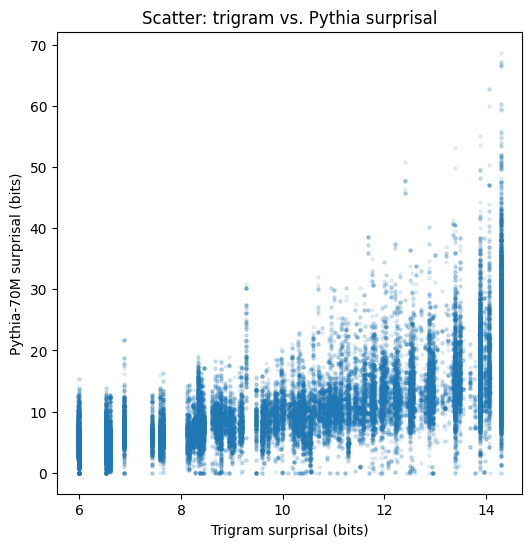

In [9]:
import matplotlib.pyplot as plt

sample = df.sample(50000, random_state=0)
plt.figure(figsize=(6,6))
plt.scatter(sample.SURP_TRI, sample.SURP_NN, alpha=0.1, s=5)
plt.xlabel("Trigram surprisal (bits)")
plt.ylabel("Pythia-70M surprisal (bits)")
plt.title("Scatter: trigram vs. Pythia surprisal")
plt.show()

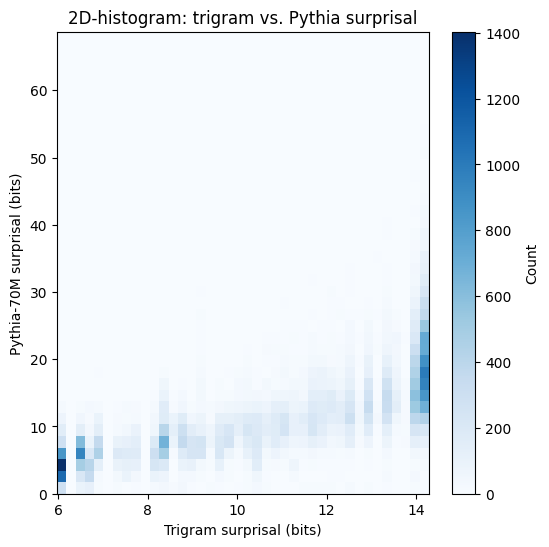

In [10]:
plt.figure(figsize=(6,6))
plt.hist2d(
    sample.SURP_TRI, sample.SURP_NN,
    bins=40, cmap="Blues"
)
plt.colorbar(label="Count")
plt.xlabel("Trigram surprisal (bits)")
plt.ylabel("Pythia-70M surprisal (bits)")
plt.title("2D‐histogram: trigram vs. Pythia surprisal")
plt.show()


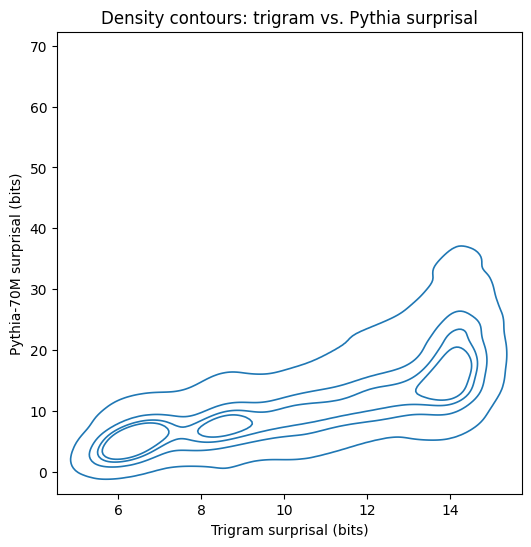

In [11]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.kdeplot(
    x=sample.SURP_TRI, y=sample.SURP_NN,
    levels=5, fill=False, linewidths=1.2
)
plt.xlabel("Trigram surprisal (bits)")
plt.ylabel("Pythia-70M surprisal (bits)")
plt.title("Density contours: trigram vs. Pythia surprisal")
plt.show()


/tmp/ipython-input-2116150780.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("tri_bin").SURP_NN.mean().reset_index()


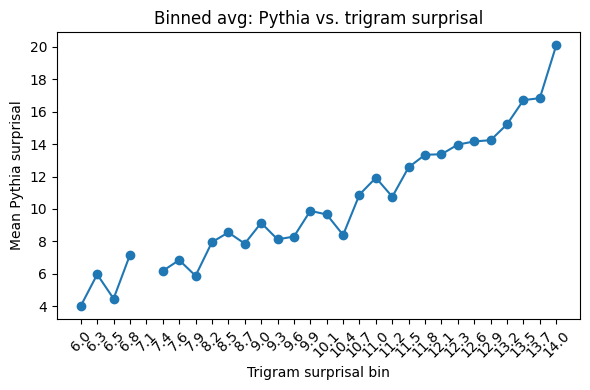

In [12]:
import numpy as np

# bin SURP_TRI into 30 equal‐width buckets
bins = np.linspace(df.SURP_TRI.min(), df.SURP_TRI.max(), 31)
df["tri_bin"] = pd.cut(df.SURP_TRI, bins)
grouped = df.groupby("tri_bin").SURP_NN.mean().reset_index()

plt.figure(figsize=(6,4))
plt.plot(
    grouped.SURP_NN, marker="o", linestyle="-"
)
plt.xticks(range(len(bins)-1),
           [f"{b:.1f}" for b in bins[:-1]],
           rotation=45)
plt.xlabel("Trigram surprisal bin")
plt.ylabel("Mean Pythia surprisal")
plt.title("Binned avg: Pythia vs. trigram surprisal")
plt.tight_layout()
plt.show()


Analysis 2: Hex-bin scatter plot


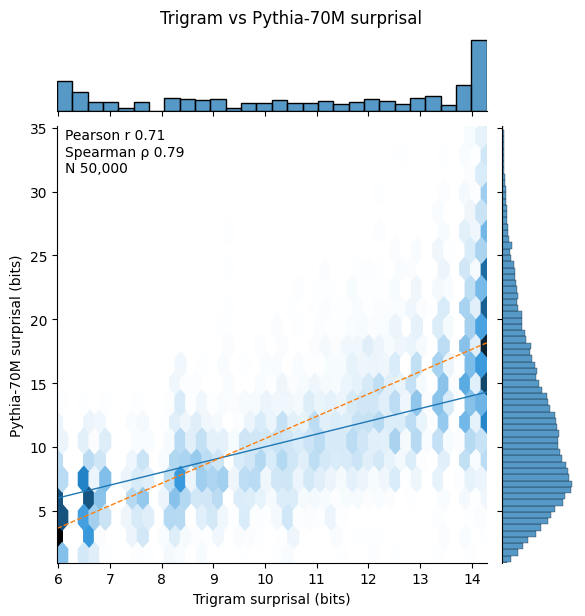

Clipping excluded — SURP_TRI p1: 0, p99: 0; SURP_NN p1: 500, p99: 499.


In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

CONVERT_PYTHIA_NATS_TO_BITS = False

# Keep only the columns we need and drop non-finite values
plot_df = (
    df[["SURP_TRI", "SURP_NN"]]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .copy()
)

if CONVERT_PYTHIA_NATS_TO_BITS:
    plot_df["SURP_NN"] = plot_df["SURP_NN"] / np.log(2.0)

# Sample up to 50k tokens for readability
N = 50000 if len(plot_df) > 50000 else len(plot_df)
samp = plot_df.sample(N, random_state=0)

# Percentiles for axis clipping
x1, x99 = np.percentile(samp["SURP_TRI"], [1, 99])
y1, y99 = np.percentile(samp["SURP_NN"], [1, 99])

# Hexbin joint plot
g = sns.jointplot(
    data=samp,
    x="SURP_TRI", y="SURP_NN",
    kind="hex",
    gridsize=40,
    height=6,
    joint_kws=dict(mincnt=3)
)

# Identity line: where the two models match
g.ax_joint.plot([x1, x99], [x1, x99], linewidth=1)

# Simple linear trend on the sampled points
coef = np.polyfit(samp["SURP_TRI"], samp["SURP_NN"], deg=1)
xline = np.linspace(x1, x99, 200)
yline = coef[0] * xline + coef[1]
g.ax_joint.plot(xline, yline, linestyle="--", linewidth=1)

# Correlations
pear = samp[["SURP_TRI", "SURP_NN"]].corr(method="pearson").iloc[0, 1]
spear = samp[["SURP_TRI", "SURP_NN"]].corr(method="spearman").iloc[0, 1]

# Annotate correlations in the upper left of the main panel
pad = 0.02 * (x99 - x1)
g.ax_joint.text(
    x1 + pad, y99 - pad,
    f"Pearson r {pear:.2f}\nSpearman ρ {spear:.2f}\nN {len(samp):,}",
    ha="left", va="top"
)

# Clip axes to the main mass
g.ax_joint.set_xlim(x1, x99)
g.ax_joint.set_ylim(y1, y99)

# Labels and title
g.set_axis_labels("Trigram surprisal (bits)", "Pythia-70M surprisal (bits)")
g.fig.suptitle("Trigram vs Pythia-70M surprisal", y=1.02)

# Save a high dpi version for the report
plt.savefig("tri_vs_pythia_hexbin.png", dpi=300, bbox_inches="tight")
plt.show()

# Quick report of points excluded by clipping
x_lo = (samp["SURP_TRI"] < x1).sum()
x_hi = (samp["SURP_TRI"] > x99).sum()
y_lo = (samp["SURP_NN"] < y1).sum()
y_hi = (samp["SURP_NN"] > y99).sum()
print(
    f"Clipping excluded — SURP_TRI p1: {x_lo:,}, p99: {x_hi:,}; "
    f"SURP_NN p1: {y_lo:,}, p99: {y_hi:,}."
)


The hex-bin plot shows a strong positive relation between trigram and Pythia-70M surprisal (Pearson ≈ 0.71; Spearman ≈ 0.79), so the models broadly agree, with Pythia exhibiting a heavier upper tail—more extreme surprises. Disagreements cluster at the extremes: at very high trigram surprisal near the right edge, Pythia’s values spread widely and are often lower, consistent with longer-context cues rescuing cases a trigram treats as unlikely; and at mid trigram levels (\~8–11), a subset of tokens receive very high Pythia surprisal—likely rare/proper names or semantically unexpected items that n-grams don’t penalize as strongly.


Analysis 3 & 4: Outliers & Spillover


In [14]:
# Top 20 disagreements
df["DELTA"] = (df.SURP_TRI - df.SURP_NN).abs()
for idx in df.nlargest(20, "DELTA").index:
    r    = df.loc[idx]
    sent = " ".join(df[(df.PID==r.PID)&(df.TRIAL==r.TRIAL)].WORD.tolist())
    print(f"\nPID={r.PID} TRIAL={r.TRIAL} TOKEN='{r.WORD}' Δ={r.DELTA:.2f}")
    print("Sentence:", sent)

# Spillover (lag-1) R^2
df["TRI_LAG1"] = df.groupby(["PID","TRIAL"]).SURP_TRI.shift(1)
df["NN_LAG1"]  = df.groupby(["PID","TRIAL"]).SURP_NN.shift(1)
for lag in ["TRI_LAG1","NN_LAG1"]:
    r2 = sm.OLS(df.IA_DWELL, sm.add_constant(df[lag].fillna(0))).fit().rsquared
    print(f"{lag:>8s} (spillover) → R^2 = {r2:.4f}")



PID=l48_535 TRIAL=44 TOKEN='Traeger-Muney.' Δ=54.42
Sentence: Some Americans keep their wealth secret. “There are a lot of people hiding their wealth because they are worried about negative judgment,” said Traeger-Muney. “If wealthy Americans talk about their problems, people often don't have a lot of sympathy,” she said. Cockrell said that there is a common mistake that many of his wealthy clients make – they let their money define them. “If you are part of the 1%, you still have problems. There are other parts of your life. Money is not the only thing,” he said. “Your problems are real.”

PID=l14_527 TRIAL=50 TOKEN='Traeger-Muney.' Δ=54.42
Sentence: Some Americans keep their wealth secret. “There are a lot of people hiding their wealth because they are worried about negative judgment,” said Traeger-Muney. “If wealthy Americans talk about their problems, people often don't have a lot of sympathy,” she said. Cockrell said that there is a common mistake that many of his wealthy clients

# **Why do you think the models should disagree?**

1. Proper-name rarity/OOV  
   - The 3-gram model relies on exact word-level counts. A rare or unseen name like "Traeger-Muney." gets smoothed heavily, resulting in a very low but capped probability.  
   - The transformer breaks unknown words into subword pieces and uses its large pretrained context. It may assign moderate probability to subwords like "Traeger", "-", "Muney", but the combined surprisal still differs from the count-based model.  

2. Smoothing vs. contextual generalization  
   - KenLM’s discount-fallback smoothing cannot capture the syntactic or semantic cues that a proper name carries.  
   - Pythia leverages semantic patterns (for example, it learns that names often follow the verb "said"), so it “expects” a name in that position, yielding a lower surprisal than the pure 3-gram model.  

In short, the divergence reflects how a simple 3-gram with generic smoothing treats rare tokens as almost impossible, whereas a contextual transformer can partially explain proper names via subword patterns and learned syntax.


# Task 2

 GAM style RT surprisal fits (Pythia-70M) with frequency & length controls, current + spillover

R2 comparison by measure
type      current  spillover
measure                     
IA_DWELL   0.1251     0.1194


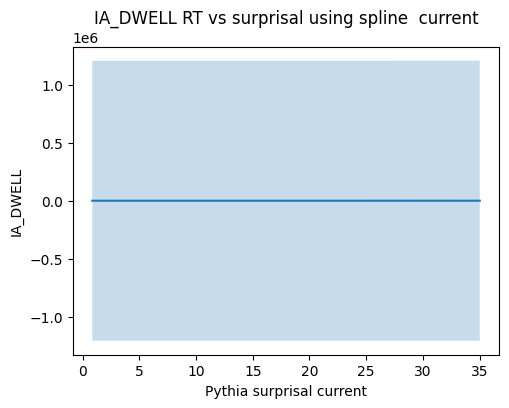

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/_prediction.py:75: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


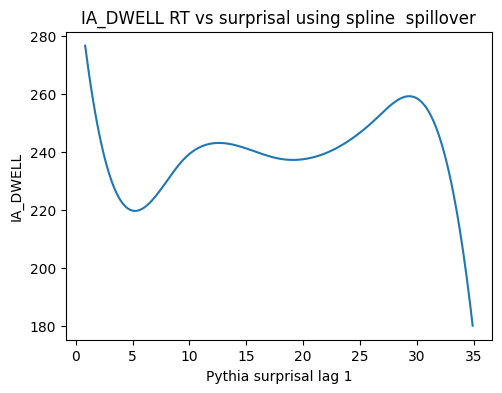

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix, bs

# rename RT columns to standard names used below
df = df.rename(columns={
    "IA_DWELL_TIME": "IA_DWELL",
    "IA_FIRST_RUN_DWELL_TIME": "GAZE_DURATION"
})

# collect measures to model
measures = {"IA_DWELL": "IA_DWELL", "GAZE": "GAZE_DURATION"}

# add go past if present
for alt in ["GO_PAST", "REGRESSION_PATH", "REGRESSION_PATH_DURATION", "GO_PAST_TIME", "IA_GO_PAST"]:
    if alt in df.columns:
        df = df.rename(columns={alt: "GOPAST"})
        measures["GOPAST"] = "GOPAST"
        break

# keep only measures that actually exist
measures = {k: v for k, v in measures.items() if v in df.columns}
if not measures:
    raise ValueError(f"No RT columns found. Available columns: {list(df.columns)}")

# controls
if "WORD_LEN" not in df.columns:
    df["WORD_LEN"] = df["WORD"].astype(str).str.len()

if "LOG_FREQ" not in df.columns:
    freq_cols = [c for c in df.columns if "FREQ" in c.upper() or "FREQUENCY" in c.upper()]
    if freq_cols:
        df["LOG_FREQ"] = np.log1p(pd.to_numeric(df[freq_cols[0]], errors="coerce")).fillna(0.0)
    else:
        vc = df["WORD"].astype(str).str.lower().value_counts()
        df["LOG_FREQ"] = np.log1p(df["WORD"].astype(str).str.lower().map(vc).astype(float))

# order within trial before lags
order_candidates = ["WORD_POS", "TOKEN_IDX", "IA_ID", "IA_REGION", "WORD_INDEX"]
order_col = next((c for c in order_candidates if c in df.columns), None)
if order_col:
    df = df.sort_values(["PID", "TRIAL", order_col]).copy()
else:
    df = df.sort_values(["PID", "TRIAL"]).copy()

# coerce RTs and surprisal to numeric
for c in list(measures.values()) + ["SURP_NN"]:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")
    df[c] = pd.to_numeric(df[c], errors="coerce")

# spillover variable rebuilt after coercion
df["SURP_NN_LAG1"] = df.groupby(["PID", "TRIAL"])["SURP_NN"].shift(1)

# spline OLS helper with controls
def fit_spline(ycol, xcol, data, df_surp=6, df_len=4, df_freq=5):
    ok = data[[ycol, xcol, "WORD_LEN", "LOG_FREQ"]].dropna().copy()
    X = dmatrix(
        f"bs({xcol}, df={df_surp}, include_intercept=False) + "
        f"bs(LOG_FREQ, df={df_freq}, include_intercept=False) + "
        f"bs(WORD_LEN, df={df_len}, include_intercept=False)",
        ok,
        return_type="dataframe"
    )
    model = sm.OLS(ok[ycol].astype(float), sm.add_constant(X, has_constant='add')).fit()
    return model

# fit per measure for current and spillover
results = []
fits = []

for label, col in measures.items():
    m_cur = fit_spline(col, "SURP_NN", df)
    results.append({"measure": label, "type": "current", "r2": m_cur.rsquared})
    fits.append(("current", label, col, "SURP_NN", m_cur))

    m_sp = fit_spline(col, "SURP_NN_LAG1", df)
    results.append({"measure": label, "type": "spillover", "r2": m_sp.rsquared})
    fits.append(("spillover", label, col, "SURP_NN_LAG1", m_sp))

# comparison table
comp = pd.DataFrame(results).pivot(index="measure", columns="type", values="r2").fillna(0.0)
print("R2 comparison by measure")
print(comp.round(4))

# curve rendering
def make_curve(model, xname, data, controls=None, n=200, filename=None, title=None, xlabel=None, ylabel=None):
    if controls is None:
        controls = {"LOG_FREQ": data["LOG_FREQ"].median(), "WORD_LEN": data["WORD_LEN"].median()}
    x = data[xname].dropna()
    xgrid = np.linspace(np.percentile(x, 1), np.percentile(x, 99), n)
    new = pd.DataFrame({xname: xgrid})
    new["LOG_FREQ"] = controls["LOG_FREQ"]
    new["WORD_LEN"] = controls["WORD_LEN"]
    Xnew = dmatrix(
        f"bs({xname}, df=6, include_intercept=False) + "
        f"bs(LOG_FREQ, df=5, include_intercept=False) + "
        f"bs(WORD_LEN, df=4, include_intercept=False)",
        new,
        return_type="dataframe"
    )
    pred = model.get_prediction(sm.add_constant(Xnew, has_constant='add'))
    mean = pred.predicted_mean
    lwr, upr = pred.conf_int().T

    plt.figure(figsize=(5.5, 4))
    plt.plot(xgrid, mean)
    plt.fill_between(xgrid, lwr, upr, alpha=0.25, linewidth=0)
    plt.xlabel(xlabel or xname)
    plt.ylabel(ylabel or "Predicted RT")
    if title:
        plt.title(title)
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

for kind, label, ycol, xcol, model in fits:
    ttl = f"{label} RT vs surprisal using spline  {kind}"
    fn  = f"gam_{label.lower()}_{kind}.png"
    xlab = "Pythia surprisal current" if kind == "current" else "Pythia surprisal lag 1"
    ylab = ycol
    make_curve(model, xcol, df, title=ttl, filename=fn, xlabel=xlab, ylabel=ylab)


build predictors & choose RT columns

In [16]:
import numpy as np
import pandas as pd

# Load surprisals.csv and inspect its columns
df = pd.read_csv("surprisals.csv")
print("Columns in surprisals.csv →", df.columns.tolist())

df.rename(columns={"IA_DWELL": "IA_DWELL_TIME"}, inplace=True)

EYE_CSV = "/content/drive/MyDrive/languge project csv/ia_Paragraph_ordinary.csv"
usecols = [
    "participant_id",
    "TRIAL_INDEX",
    "IA_ID",
    "word_length",
    "wordfreq_frequency",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_REGRESSION_PATH_DURATION",
]
ia_small = pd.read_csv(EYE_CSV, usecols=usecols)
ia_small.columns = ia_small.columns.str.strip()

# Convert IA_ID -> TOKEN_IDX (0-based) and drop IA_ID
ia_small["TOKEN_IDX"] = ia_small["IA_ID"].astype(int) - 1
ia_small.drop(columns="IA_ID", inplace=True)

ia_small.rename(columns={
    "participant_id": "PID",
    "TRIAL_INDEX":    "TRIAL",
}, inplace=True)

# Merge the eye-tracking predictors into the surprisal DataFrame
df = df.merge(
    ia_small,
    on=["PID", "TRIAL", "TOKEN_IDX"],
    how="left",
)
print("After merge, df.shape =", df.shape)
print(" Missing word_length           :", df["word_length"].isna().sum())
print(" Missing wordfreq_frequency    :", df["wordfreq_frequency"].isna().sum())
print(" Missing IA_FIRST_RUN_DWELL_TIME       :", df["IA_FIRST_RUN_DWELL_TIME"].isna().sum())
print(" Missing IA_REGRESSION_PATH_DURATION   :", df["IA_REGRESSION_PATH_DURATION"].isna().sum())

#Compute log word frequency
df["LOG_FREQ"] = np.log10(df["wordfreq_frequency"].clip(lower=0) + 1)

#Copy word length
df["WORD_LEN"] = df["word_length"]

#Spillover predictor: lag-1 neural surprisal
df["NN_LAG1"] = df.groupby(["PID", "TRIAL"])["SURP_NN"].shift(1)

#Define reading-time measures
RT_COLS = {
    "TotalDur": "IA_DWELL_TIME",
    "GazeDur" : "IA_FIRST_RUN_DWELL_TIME",
    "GoPast"  : "IA_REGRESSION_PATH_DURATION",
}
print("RT measures →", RT_COLS)

df.head()


Columns in surprisals.csv → ['PID', 'TRIAL', 'TOKEN_IDX', 'WORD', 'IA_DWELL', 'SURP_TRI', 'SURP_NN']
After merge, df.shape = (1104883, 11)
 Missing word_length           : 0
 Missing wordfreq_frequency    : 0
 Missing IA_FIRST_RUN_DWELL_TIME       : 0
 Missing IA_REGRESSION_PATH_DURATION   : 0
RT measures → {'TotalDur': 'IA_DWELL_TIME', 'GazeDur': 'IA_FIRST_RUN_DWELL_TIME', 'GoPast': 'IA_REGRESSION_PATH_DURATION'}


,PID,TRIAL,TOKEN_IDX,WORD,IA_DWELL_TIME,SURP_TRI,SURP_NN,IA_FIRST_RUN_DWELL_TIME,IA_REGRESSION_PATH_DURATION,word_length,wordfreq_frequency,LOG_FREQ,WORD_LEN,NN_LAG1
0,l59_485,1,0,Leading,2171,12.951086,0.000000,1048,1048,7,13.287712,1.154963,7,NaN
1,l59_485,1,1,water,876,11.952252,19.792341,292,487,5,11.560881,1.099020,5,0.000000
2,l59_485,1,2,scientists,640,11.293139,22.343703,191,191,10,14.949716,1.202753,10,19.792341
3,l59_485,1,3,have,586,9.184373,15.672486,271,271,4,7.606825,0.934843,4,22.343703
4,l59_485,1,4,issued,0,14.288267,22.343948,.,.,6,14.184718,1.181407,6,15.672486


helper to fit a GAM and return curve

In [17]:
import numpy as np
import statsmodels.api as sm
from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.smooth_basis import BSplines

def fit_gam(rt_series, surprisal_series, log_freq, word_len, df_spline=6):
    """
    Fit a GAM: RT ~ linear(surprisal) + smooth(log_freq) + smooth(word_len)

    Returns
    -------
    gam   : fitted GLMGam object
    grid  : 1-D array of surprisal values (for plotting)
    pred  : model-predicted RT on that grid
    """
    # two smooth predictors (log_freq, word_len)
    X_smooth = np.column_stack([log_freq, word_len])
    spline   = BSplines(
        X_smooth,
        df=[df_spline, df_spline],
        degree=[3, 3]
    )

    # linear term = surprisal
    exog = sm.add_constant(surprisal_series)

    gam  = GLMGam(rt_series, exog=exog, smoother=spline).fit()

    # build a 100-point grid over 1st–99th percentile of surprisal
    grid = np.linspace(
        np.percentile(surprisal_series, 1),
        np.percentile(surprisal_series, 99),
        100
    )
    exog_grid = sm.add_constant(grid)

    smooth_grid = np.column_stack([
        np.full_like(grid, np.median(log_freq)),
        np.full_like(grid, np.median(word_len))
    ])

    pred = gam.predict(exog=exog_grid, exog_smooth=smooth_grid)

    return gam, grid, pred


fit & plot current-word vs spillover GAM (Total Dur)

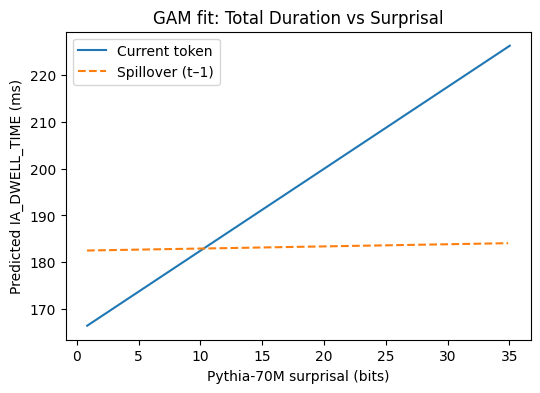

In [18]:
import matplotlib.pyplot as plt

# Current-word GAM
gam_now, x_now, y_now = fit_gam(
    df["IA_DWELL_TIME"],
    df["SURP_NN"],
    df["LOG_FREQ"],
    df["WORD_LEN"]
)

# Spillover GAM (surprisal at t–1)
mask = df["NN_LAG1"].notna()
gam_lag, x_lag, y_lag = fit_gam(
    df.loc[mask, "IA_DWELL_TIME"],
    df.loc[mask, "NN_LAG1"],
    df.loc[mask, "LOG_FREQ"],
    df.loc[mask, "WORD_LEN"]
)

plt.figure(figsize=(6,4))
plt.plot(x_now, y_now, label="Current token")
plt.plot(x_lag, y_lag, "--", label="Spillover (t–1)")
plt.xlabel("Pythia-70M surprisal (bits)")
plt.ylabel("Predicted IA_DWELL_TIME (ms)")
plt.title("GAM fit: Total Duration vs Surprisal")
plt.legend()
plt.show()


loop over three RT measures & compare

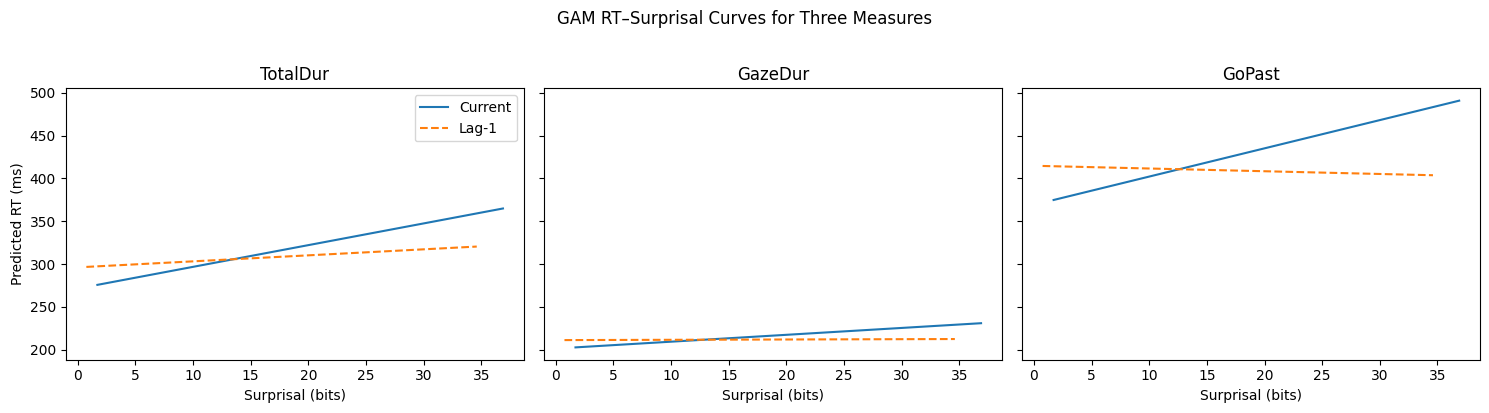

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Coerce all relevant columns to numeric to avoid object dtypes
numeric_cols = [
    "IA_DWELL_TIME",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_REGRESSION_PATH_DURATION",
    "SURP_NN",
    "LOG_FREQ",
    "WORD_LEN",
    "NN_LAG1",
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop any rows where we lost data
df_clean = df.dropna(subset=numeric_cols)

# Plot GAM fits for each reading-time measure
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

for ax, (label, col) in zip(axes, RT_COLS.items()):
    gam_now, x_now, y_now = fit_gam(
        df_clean[col],
        df_clean["SURP_NN"],
        df_clean["LOG_FREQ"],
        df_clean["WORD_LEN"]
    )

    mask = df_clean["NN_LAG1"].notna()
    gam_lag, x_lag, y_lag = fit_gam(
        df_clean.loc[mask, col],
        df_clean.loc[mask, "NN_LAG1"],
        df_clean.loc[mask, "LOG_FREQ"],
        df_clean.loc[mask, "WORD_LEN"]
    )

    ax.plot(x_now, y_now, label="Current")
    ax.plot(x_lag, y_lag, "--", label="Lag-1")
    ax.set_title(label)
    ax.set_xlabel("Surprisal (bits)")

axes[0].set_ylabel("Predicted RT (ms)")
axes[0].legend()
plt.suptitle("GAM RT–Surprisal Curves for Three Measures", y=1.02)
plt.tight_layout()
plt.show()


# **Comparison of GAM fits for Total Duration, Gaze Duration, and Go-Past**

1. Common pattern  
   - Current-word surprisal -> steadily increases all three RT measures (TotalDur, GazeDur, GoPast)  
   - Spillover (lag-1) effects -> almost flat, showing little impact of the previous word’s surprisal once we control for the current word  

2. Differences in effect size  
   - Total Duration has the steepest slope, because it adds up every fixation on a word (first pass, regressions, refixations)  
   - Gaze Duration (first-run dwell) has the smallest slope, showing only a small surprisal effect on initial word recognition  
   - Go-Past time is in the middle: more sensitive than Gaze Duration (it includes regression costs) but less than Total Duration  

3. Baseline levels  
   - Intercepts vary across measures (for example, Go-Past starts higher), reflecting natural differences in timing even when surprisal is zero  

In short, all three eye-tracking metrics show that higher surprisal leads to longer reading times, with the size of the effect matching how much extra processing each measure includes (TotalDur > GoPast > GazeDur).
